# Example 2: MPNN redesign of some DHRs with repeat symmetry into AF2
Variables in ALL_CAPS are the ones you should change

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/demos
running on node: dig162


### Set working directory to the root of the crispy_shifty repo
**Change this to wherever you cloned it**

In [2]:
WORKING_DIRECTORY = "/projects/crispy_shifty"

os.chdir(WORKING_DIRECTORY)

sys.path.insert(0, "/projects/crispy_shifty")

### Prep a list of designs
To do this, you'll need a list with the fullpath of your designs, one per line.
Here's how to do it with python, you could also `cd <dir full of your designs> ; realpath *.pdb > designs.list` or some such

In [3]:
import shutil

# we'll use TJ's DHRs for this demo, change this to the location of your designs
INPUT_PATH = os.path.join(os.getcwd(), "demos/mpnn_to_af2_example_2/inputs")
os.makedirs(INPUT_PATH, exist_ok=True)
# we'll use a directory in demos for our output, you should change this too
OUTPUT_PATH = os.path.join(os.getcwd(), "demos/mpnn_to_af2_example_2/outputs")
os.makedirs(OUTPUT_PATH, exist_ok=True)
# copy over the example inputs if they aren't there already
pdbs = os.listdir(INPUT_PATH)
if len(pdbs) == 0:
    for file in glob(
        "/projects/crispy_shifty/demos/mpnn_to_af2_example_2/inputs/DHR*.pdb"
    ):
        shutil.copy(file, INPUT_PATH)
else:
    pass
inputs_list = os.path.join(INPUT_PATH, "inputs.list")
# 'with open' statement is a context manager, when we exit the with statement,
# the file is closed, preventing filesystem errors
with open(inputs_list, "w") as f:
    for pdb in glob(os.path.join(INPUT_PATH, "DHR*.pdb")):
        print(pdb, file=f)

### Run MPNN to redesign entire DHRs with repeat symmetry
We'll make array tasks since that is easiest, if you need to profile your code or want better analytics, you should use the `dask` stack, just be aware that it can only scale up to around 20k CPU hours or so on the digs

In [4]:
# since we set the working dir to the root of the repo, python knows where to load this
from crispy_shifty.utils.io import gen_array_tasks

SIMULATION_NAME = "mpnn_dhr_with_repeat"  # change this to whatever you want
design_list_file = inputs_list  # the file we just made

# this is the relative path from the root of the repo to .py file
# `crispy_shifty/protocols/demos.py` and `mpnn_dhr_with_repeat` is the function in the file
DISTRIBUTE_FUNC = "crispy_shifty.protocols.demos.mpnn_dhr_with_repeat"

# pyrosetta init options
OPTIONS = " ".join(
    [
        "out:level 200",  # warnings and errors only, normal output is 300
    ]
)
# options for controlling function behavior
EXTRA_OPTIONS = {
    "num_sequences": "16",  # should be a multiple of 8
}

QUEUE = "medium"  # change if needed
MEMORY = "4G"  # change if needed
SHA1 = (
    None  # change this to "" when you are ready to do a production run in your branch
)
# if SHA1 is not None, save the notebook and `git commit -am "SOME MESSAGE"` ;
# then `git push; sleep 15` in your branch before running this cell

gen_array_tasks(
    distribute_func=DISTRIBUTE_FUNC,
    design_list_file=design_list_file,
    output_path=OUTPUT_PATH,  # the output dir we just made
    queue=QUEUE,
    memory=MEMORY,
    nstruct=1,
    nstruct_per_task=1,
    options=OPTIONS,
    extra_kwargs=EXTRA_OPTIONS,
    sha1=SHA1,
    simulation_name=SIMULATION_NAME,
)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Run the following command with your desired environment active:
sbatch -a 1-8 /mnt/projects/crispy_shifty/demos/mpnn_to_af2_example_2/outputs/run.sh


In [5]:
!sbatch -a 1-8 /mnt/projects/crispy_shifty/demos/mpnn_to_af2_example_2/outputs/run.sh

Submitted batch job 28981569


### Collect scorefiles of designed dhrs and concatenate
**Change this to wherever you cloned it**

In [6]:
CLONE_LOC = "/projects/crispy_shifty"
sys.path.insert(0, CLONE_LOC)
from crispy_shifty.utils.io import collect_score_file

simulation_name = SIMULATION_NAME
output_path = OUTPUT_PATH

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

### Load resulting concatenated scorefile

In [7]:
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = OUTPUT_PATH

scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))
scores_df = scores_df.convert_dtypes()

  0%|          | 0/136 [00:00<?, ?it/s]

### Data exploration
As we can see, the sequences were added to the decoy scores

In [8]:
scores_df.columns

Index(['dslf_fa13', 'fa_atr', 'fa_dun', 'fa_elec', 'fa_intra_rep',
       'fa_intra_sol_xover4', 'fa_rep', 'fa_sol', 'hbond_bb_sc', 'hbond_lr_bb',
       'hbond_sc', 'hbond_sr_bb', 'lk_ball_wtd', 'mpnn_seq_0000',
       'mpnn_seq_0001', 'mpnn_seq_0002', 'mpnn_seq_0003', 'mpnn_seq_0004',
       'mpnn_seq_0005', 'mpnn_seq_0006', 'mpnn_seq_0007', 'mpnn_seq_0008',
       'mpnn_seq_0009', 'mpnn_seq_0010', 'mpnn_seq_0011', 'mpnn_seq_0012',
       'mpnn_seq_0013', 'mpnn_seq_0014', 'mpnn_seq_0015', 'mpnn_seq_0016',
       'omega', 'original_sequence', 'p_aa_pp', 'parent', 'path_in',
       'pro_close', 'rama_prepro', 'ref', 'total_score', 'yhh_planarity'],
      dtype='object')

### Save a list of chunked outputs
20 per chunk, we can then fold 20 at a time

In [9]:
from more_itertools import ichunked

with open(os.path.join(output_path, "mpnn_dhr_with_repeat.pair"), "w") as f:
    for paths in ichunked(tqdm(scores_df.index), 20):
        line = "____".join(paths)
        print(line, file=f)

  0%|          | 0/136 [00:00<?, ?it/s]

### Run Superfold to fold the DHRs with redesigned sequences

In [10]:
# since we set the working dir to the root of the repo, python knows where to load this
from crispy_shifty.utils.io import gen_array_tasks

SIMULATION_NAME = "batch_fold_dhr"  # change this to whatever you want
design_list_file = os.path.join(
    output_path, "mpnn_dhr_with_repeat.pair"
)  # the file we just made

# this is the relative path from the root of the repo to .py file
# `crispy_shifty/protocols/demos.py` and `batch_fold_dhr` is the function in the file
DISTRIBUTE_FUNC = "crispy_shifty.protocols.demos.batch_fold_dhr"

# we'll use a directory in demos for our output, you should change this too
OUTPUT_PATH = os.path.join(os.getcwd(), "demos/mpnn_to_af2_example_2/folded")
os.makedirs(OUTPUT_PATH, exist_ok=True)

# pyrosetta init options
OPTIONS = " ".join(
    [
        "out:level 200",  # warnings and errors only, normal output is 300
    ]
)
# options for controlling function behavior
EXTRA_OPTIONS = {"models": "all"}

QUEUE = "gpu"  # change if needed, could use medium instead for example
MEMORY = "6G"  # change if needed
GRES = "--gres=gpu:rtx2080:1"
SHA1 = (
    None  # change this to "" when you are ready to do a production run in your branch
)
# if SHA1 is not None, save the notebook and `git commit -am "SOME MESSAGE"` ;
# then `git push; sleep 15` in your branch before running this cell

gen_array_tasks(
    distribute_func=DISTRIBUTE_FUNC,
    design_list_file=design_list_file,
    output_path=OUTPUT_PATH,  # the output dir we just made
    queue=QUEUE,
    memory=MEMORY,
    gres=GRES,
    nstruct=1,
    nstruct_per_task=1,
    options=OPTIONS,
    extra_kwargs=EXTRA_OPTIONS,
    sha1=SHA1,
    simulation_name=SIMULATION_NAME,
)

Run the following command with your desired environment active:
sbatch -a 1-7 /mnt/projects/crispy_shifty/demos/mpnn_to_af2_example_2/folded/run.sh


In [11]:
!sbatch -a 1-7 /mnt/projects/crispy_shifty/demos/mpnn_to_af2_example_2/folded/run.sh

Submitted batch job 28981879


### Collect scorefiles of folded dhrs and concatenate
**Change this to wherever you cloned it**

In [3]:
CLONE_LOC = "/projects/crispy_shifty"
sys.path.insert(0, CLONE_LOC)
from crispy_shifty.utils.io import collect_score_file

SIMULATION_NAME = "batch_fold_dhr"
OUTPUT_PATH = os.path.join(os.getcwd(), "demos/mpnn_to_af2_example_2/folded")
simulation_name = SIMULATION_NAME
output_path = OUTPUT_PATH

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile

In [4]:
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = OUTPUT_PATH

scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))
scores_df = scores_df.convert_dtypes()

  0%|          | 0/136 [00:00<?, ?it/s]

### Remove score terms we don't care about

In [5]:
from crispy_shifty.protocols.design import beta_nov16_terms

scores_df = scores_df[
    [
        term
        for term in scores_df.columns
        if term not in beta_nov16_terms and "mpnn_seq" not in term
    ]
]
print(len(scores_df))
print(list(scores_df.columns))

136
['SAP', 'elapsed_time', 'final_seq', 'mean_pae', 'mean_pae_interaction', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_plddt', 'model', 'original_sequence', 'pTMscore', 'parent', 'path_in', 'recycles', 'rmsd_to_input', 'sap_score', 'seed', 'tol', 'total_score', 'type']


### Data exploration
Compare rosetta sequences to MPNN sequences and plot

In [6]:
def row2design_type(row: pd.Series) -> str:
    if row["original_sequence"] == row["final_seq"]:
        design_type = "rosetta"
    else:
        design_type = "mpnn"
    return design_type


scores_df["design_type"] = scores_df.progress_apply(row2design_type, axis=1)

  0%|          | 0/136 [00:00<?, ?it/s]

### Setup for plotting

In [7]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

In [8]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

to_plot = [
    "mean_pae",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_input",
    "sap_score",
]
print(to_plot)

['mean_pae', 'mean_plddt', 'pTMscore', 'rmsd_to_input', 'sap_score']


5it [00:00, 24.76it/s]


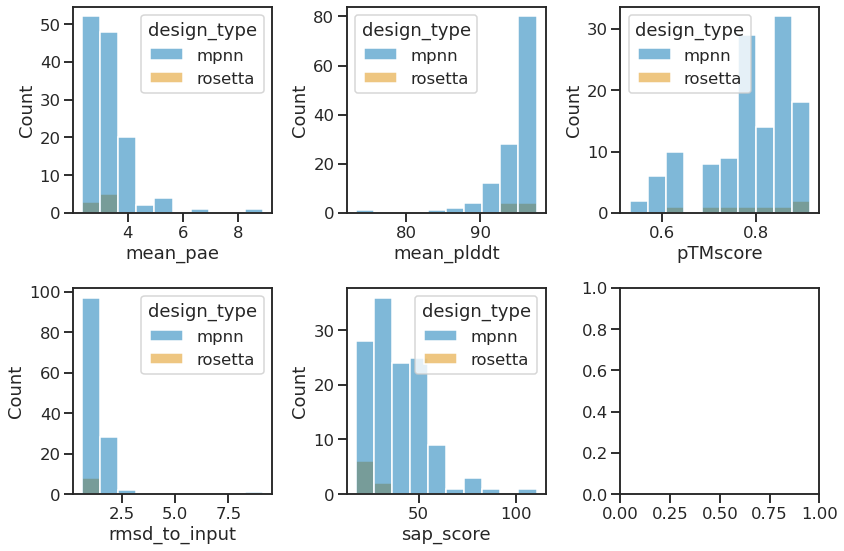

In [9]:
the_fig = histplot_df(
    df=scores_df,
    cols=to_plot,
    bins=10,
    hue="design_type",
)

<Figure size 1440x1440 with 0 Axes>

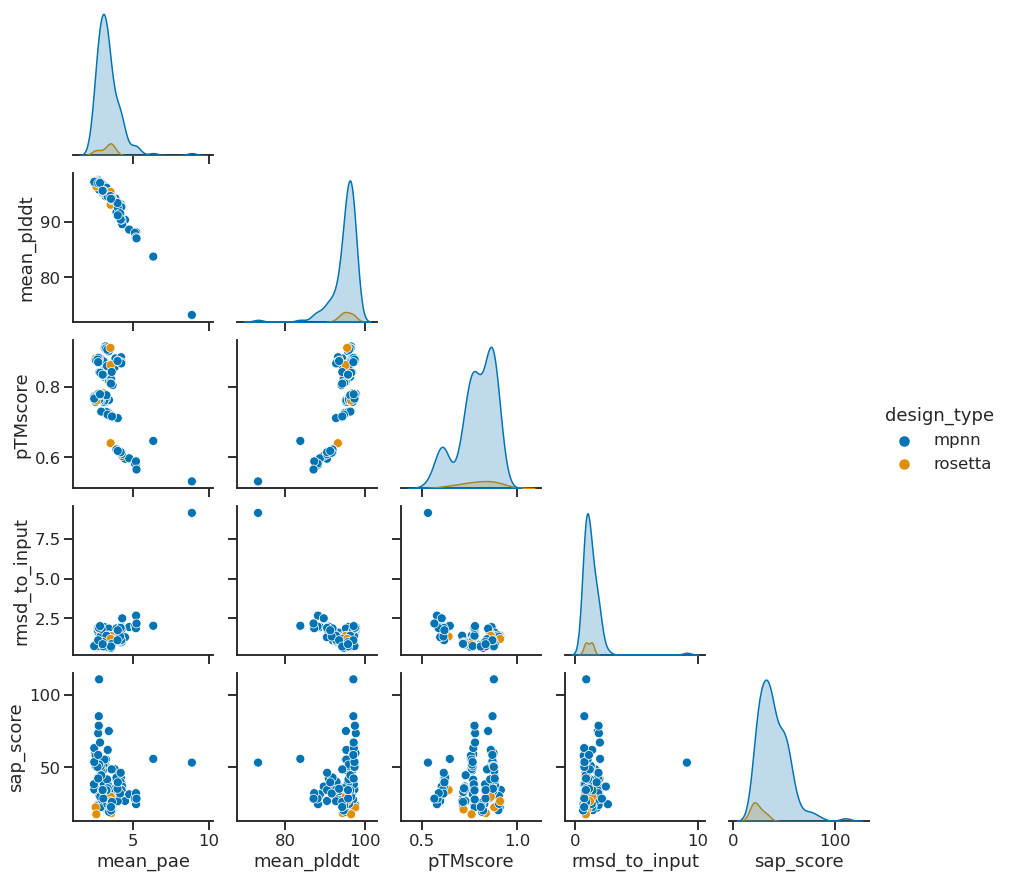

In [10]:
the_fig = pairplot_df(
    df=scores_df,
    cols=to_plot,
    hue="design_type",
)

5it [00:01,  4.55it/s]


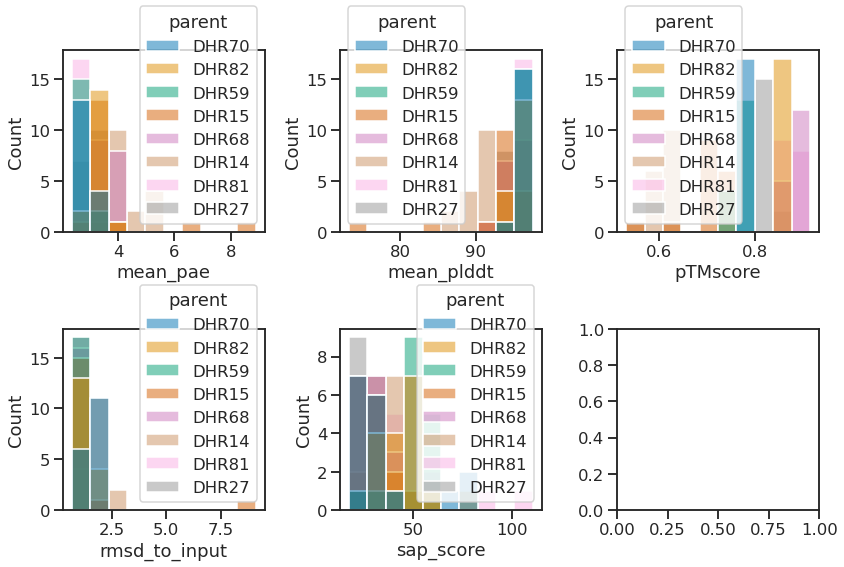

In [11]:
the_fig = histplot_df(
    df=scores_df,
    cols=to_plot,
    bins=10,
    hue="parent",
)

<Figure size 1440x1440 with 0 Axes>

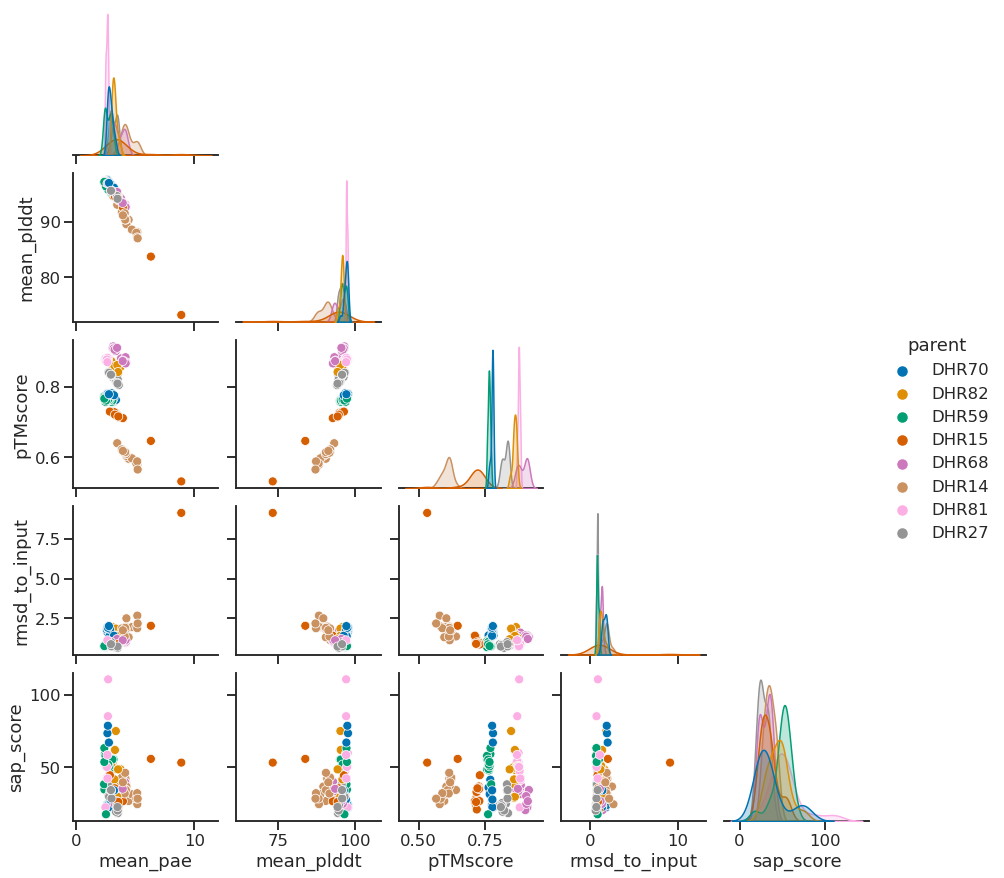

In [12]:
the_fig = pairplot_df(
    df=scores_df,
    cols=to_plot,
    hue="parent",
)

### Sort
Split into rosetta/mpnn

In [13]:
mpnn, rosetta = scores_df.query("design_type == 'mpnn'"), scores_df.query(
    "design_type == 'rosetta'"
)

### Filter
Get 3 good mpnn designs: best SAP, best PTM, and lowest RMSD
Remember to discard duplicates

In [14]:
good_mpnn = mpnn.query("mean_plddt > 90 and rmsd_to_input < 1.5")

to_order = {}

for parent in sorted(set(scores_df.parent.values)):
    rosetta_design = rosetta.query(f"parent == @parent").index[0]
    mpnn_designs = good_mpnn.query(f"parent == @parent")
    lowest_sap = mpnn_designs[
        mpnn_designs.sap_score == mpnn_designs.sap_score.min()
    ].index[0]
    mpnn_designs.drop(lowest_sap, axis=0, inplace=True)
    highest_ptm = mpnn_designs[
        mpnn_designs.pTMscore == mpnn_designs.pTMscore.max()
    ].index[0]
    mpnn_designs.drop(highest_ptm, axis=0, inplace=True)
    lowest_rmsd = mpnn_designs[
        mpnn_designs.rmsd_to_input == mpnn_designs.rmsd_to_input.min()
    ].index[0]
    to_order[f"{parent}og"] = rosetta_design
    to_order[f"{parent}m1"] = lowest_sap
    to_order[f"{parent}m2"] = highest_ptm

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

### Save a df of order

In [15]:
def row2name(row: pd.Series) -> str:
    name = pdb2name[row.name]
    return name


pdb2name = {v: k for k, v in to_order.items()}

to_order_df = scores_df.loc[list(to_order.values())]
to_order_df["name"] = to_order_df.progress_apply(row2name, axis=1)

  0%|          | 0/24 [00:00<?, ?it/s]

In [16]:
OUTPUT_PATH = os.path.join(os.getcwd(), "demos/mpnn_to_af2_example_2/to_order")
os.makedirs(OUTPUT_PATH, exist_ok=True)
to_order_df.to_csv(
    os.path.join(output_path, "final_scores.csv"), index="name", index_label="pdb"
)

### Save a folder of PDBs

In [17]:
import bz2, shutil

OUTPUT_PATH = "/projects/crispy_shifty/demos/mpnn_to_af2_example_2/to_order/pdbs/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

for k, v in to_order.items():
    with open(v, "rb") as f:  # read bz2 bytestream, decompress and decode
        pdbstring = bz2.decompress(f.read()).decode()
        with open(os.path.join(OUTPUT_PATH, f"{k}.pdb"), "w") as fout:
            print(pdbstring, file=fout)

### Make an order with scripts from Ryan and Basile/Lukas

In [22]:
cmd = f"python /projects/crispy_shifty/scripts/JohnBercow.py \
--order_pdbs {OUTPUT_PATH} --design_prefix d_ --design_id 1 \
--gg_vector LM0627 --idt_score 6.9 --no_layout --order_name m \
--species e_coli --verbose"
print(cmd)

python /projects/crispy_shifty/scripts/JohnBercow.py --order_pdbs /projects/crispy_shifty/demos/mpnn_to_af2_example_2/to_order/pdbs/ --design_prefix d_ --design_id 1 --gg_vector LM0627 --idt_score 6.9 --no_layout --order_name m --species e_coli --verbose


In [23]:
!{cmd}

Extracting sequences from PDBs...
/projects/crispy_shifty/demos/mpnn_to_af2_example_2/to_order/pdbs/
Number of AA sequences extracted: 24

>>> [1/24] DHR14m1: EKEIKKKVEKLAEKAKKETDKETIIEIVKELAELAKESKDSELIKKIVEELAKVAKKETDKETIIEIVKELAELAKYSKDSELIKKIVEELAKVAKKETDKETIIEIVKELAELAKYSKDSELIKKIKEELKKVAKKETDKETKEEIKKVLEELEKLSKE
  Reverse translating (optimising for e_coli with kmers_weight@10.0)...
  [!] DNA sequence(s) failed the complexity test from IDT (Total Complexity Score = 25.0). Trying again...
  Reverse translating (optimising for e_coli with kmers_weight@20.0)...
  [!] DNA sequence(s) failed the complexity test from IDT (Total Complexity Score = 7.6). Trying again...
  Reverse translating (optimising for e_coli with kmers_weight@30.0)...
  DNA sequence(s) passed the complexity test from IDT (Total Complexity Score = 1.2).
  Final eBlock(s):
  - eBlock  (518 bp): atactacggtctcaaggaGAAAAGGAAATTAAGAAGAAAGTTGAGAAACTGGCGGAGAAAGCAAAGAAGGAAACCGACAAGGAAACCATTATTGAAATCGTGAAGGAACTCGCGGAATTAGCCA